Lecture 11: Numerical Linear Algebra
===

We want to solve linear systems

$$
A \mathbf{x} = \mathbf{b},
$$

with a general $n\times m$ matrix $A$ and $n\times 1$ right hand side $\mathbf{b}$.

We will consider three methods of varying generality for dense $A$:

* The LU decomposition for invertible $A$
* The Cholesky decomposition for symmetric, positive definite matrices
* The QR decomposition for general $n\times m$ matrices

Why do we need different algorithms for the same problem?
This allows us to exploit special structure of the matrices we consider.
It turns out that the Cholesky decomposition is roughly 2 times
faster than the LU decomposition.
Usually, we don't care about prefactors when we make a computational cost
analysis, but what if you have a huge matrix equation to solve?
The difference between a single solve operation taking one day vs. 2 days can
be immense!

LU factorization
---

Let us assume that we can decompose a square matrix $A$ as the product

$$
A = LU,
$$

where $L$ is square and lower-triangular:

$$
L = \begin{pmatrix}
1 & 0 & ... & 0 \\
* & 1 & ... & 0  \\
\vdots & & \ddots & 0  \\
* &  ... & * &  1
\end{pmatrix},
$$
where we arbitrarily decided to set all diagonal elements to 1.

and $U$ is square and upper-triangular:
$$
U = \begin{pmatrix}
* & * & ... & & * \\
0 & * & ... & & * \\
0 & 0 & \ddots & & \vdots \\
\vdots & & & & \\
0 & 0 & ... & 0 & *
\end{pmatrix}.
$$

Let us now calculate the elements of $L$ and $U$ directly (assuming that this can be done).
We use the fact that for the components of $A, L, U$:

\begin{align*}
A_{ij} &= \sum_{k=1}^j L_{ik} U_{kj}, \qquad i > j \\
A_{ij} &= \sum_{k=1}^i L_{ik} U_{kj}, \qquad j \geq i
\end{align*}

where we used the fact that $L_{ij} = 0$ for $j > i$ and
$U_{ij} = 0$ for $i > j$. We can now rearrange these two cases separately:

\begin{align*}
L_{ij} &= \frac{1}{U_{jj}} \left( A_{ij} - \sum_{k=1}^{j-1} L_{ik} U_{kj} \right)
&\qquad i > j, i=2,\dots,N \\
U_{ij} &= A_{ij} - \sum_{k=1}^{i-1} L_{ik} U_{kj} &\qquad j \geq i, j=1,\dots, N
\end{align*}

where we used our normalization $L_{ii} = 1$.
These formulas allow us to compute the elements of $L$ and $U$ iteratively.
For example, we can start with the first row of $U$:

\begin{align*}
U_{1j} &= A_{1j}.
\end{align*}

Next, we compute the first column of $L$:

$$
L_{i1} = \frac{A_{i1}}{U_{11}}.
$$

Then we can use this information to compute $U_{2j}$, $L_{i2}$, and so on,
always plugging in the information we computed in the previous step.
As long as all $U_{ii} \neq 0$, this method can be used to construct $A=LU$,
the LU factorization.

It turns out that not all matrices can be factorized in this way directly.
However, there always exists a $n\times n$ *permutation matrix* $P$
(a permutation matrix is an identity matrix whose rows or columns have been
permuted. Its effect is to permute the rows and columns of the vectors/matrices
it is multiplied by) such that

$$
P A = L U
$$

exists and can be computed using the algorithm above. 
The proof is by induction on the matrix size $n$ and can be found,
for example in Suli and Meyers (Theorem 2.2).

*Note:* One can show that the LU factorization with permutation matrix is
equivalent to the Gaussian Elimination algorithm with pivoting.

In [11]:
using PyPlot
PyPlot.svg(true)

true

In [12]:
# Julia can compute the LU factorization of a matrix
using LinearAlgebra

A = [1 2
     4 2]

LUfact = lu(A)

LU{Float64,Array{Float64,2}}
L factor:
2×2 Array{Float64,2}:
 1.0  0.0
 4.0  1.0
U factor:
2×2 Array{Float64,2}:
 1.0   2.0
 0.0  -6.0

In [13]:
L, U = LUfact.L, LUfact.U

L*U

2×2 Array{Float64,2}:
 1.0  2.0
 4.0  2.0

Solving linear equations using the LU factorization
---

Remember that we wanted to solve

$$
A \mathbf{x} = \mathbf{b}.
$$

We can rewrite this as

$$
LU \mathbf{x} = \mathbf{b},
$$

which we again convert into *two* linear problems:

\begin{align}
L \mathbf{y} &= \mathbf{b} \\
U \mathbf{x} &= \mathbf{y}.
\end{align}

(Plug the second one into the first one to see that this is true!)

These two problems are now really easy to solve because the matrices involved
are upper and lower triangular.

Forward substitution
---

We first solve the system $L \mathbf{y} = \mathbf{b}$ using *forward substitution*.
In coordinates, the system reads (we use that $L_{ij} = 0$ for $j>i$)

$$
\sum_{k=1}^{i} L_{ik} y_k = b_i,
$$

or, using $L_{ii} = 1$ 
\begin{align}
y_1 &= b_1 \\
y_2 &= b_2 - L_{21} y_1 \\
y_3 &= b_3 - L_{32} y_2 - L_{31} y_1 \\
\dots \\
y_j &= b_j - \sum_{k=1}^{j-1} L_{jk} y_k.
\end{align}

We can compute each successive $y_j$ using the knowledge of all the previous
$y_{i < j}$. This is the forward substitution algorithm for lower triangular matrices.

Note that if $L_{ii} \neq 1$, we have
$$
y_j = \frac{1}{L_{jj}} \left( b_j - \sum_{k=1}^{j-1} L_{jk} y_k\right).
$$

Backsubstitution
---

Now that we have $\mathbf{y}$, let's try and solve $U \mathbf{x} = \mathbf{y}$
to get that vector $\mathbf{x}$ we so desperatly want!

Again, we write in coordinates (using $U_{ij} = 0$ for $i>j$)

$$
\sum_{k=j}^n U_{jk} x_k = y_j.
$$

This time, we see that it is possible to compute $x_n$ directly:

\begin{align}
U_{nn} x_n = y_n \Rightarrow x_n = \frac{y_n}{U_{nn}}.
\end{align}

Continue from the back:

\begin{align}
x_n &= \frac{y_n}{U_{nn}} \\
x_{n-1} &= \frac{y_{n-1} - U_{n-1,n} x_n}{U_{n-1, n-1}} \\
x_{n-2} &= \frac{y_{n-2} - U_{n-2,n} x_n - U_{n-2,n-1} x_{n-1}}{U_{n-2,n-2}} \\
\dots \\
x_j &= \frac{1}{U_{jj}} \left( y_j - \sum_{k=j+1}^n U_{jk} x_k \right)
\end{align}

Each successive $x_j$, going backwards from $x_n$, can be computed using
only the previously computed information.

Algorithm for solving general linear systems
---

We can now finally formulate the an algorithm for solving
linear systems $A\mathbf{x} = \mathbf{b}$:

* Compute the LU decomposition $A = LU$ (or $PA = LU$ if necessary)
* Solve $L\mathbf{y} = \mathbf{b}$ using forward substitution (or $L\mathbf{y} = P\mathbf{b}$ if necessary)
* Solve $U\mathbf{x} = \mathbf{y}$ using backsubstitution

In [14]:
# this is exactly what Julia's backslash operator does internally!
# Sometimes we would like to solve very large systems.
# It becomes important to know how long such a linear solve takes
using LinearAlgebra

Ns = [1, 10, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 12000, 16000]

times = zeros(size(Ns))

for (i, N) in enumerate(Ns)
    # random matrices
    A = rand(N, N)
    b = rand(N)
    
    # solve and measure the time it takes.
    # We explicitly use the lu function from the LinearAlgebra package to generate the decomposition.
    # The backslash operator then takes care of forward and backsubstitution
    time = @elapsed A_lu = lu(A); A_lu \ b
    times[i] = time
    
    println("N = $(N) took $(time) seconds.")
end

N = 1 took 4.765e-6 seconds.
N = 10 took 4.847e-6 seconds.
N = 100 took 0.056877588 seconds.
N = 500 took 0.228551016 seconds.
N = 1000 took 0.14787902 seconds.
N = 2000 took 0.204568532 seconds.
N = 3000 took 0.440533216 seconds.
N = 4000 took 0.820366345 seconds.
N = 5000 took 1.566361391 seconds.
N = 6000 took 2.540045843 seconds.
N = 7000 took 3.972110419 seconds.
N = 8000 took 5.908459852 seconds.
N = 12000 took 19.820180966 seconds.
N = 16000 took 46.100111972 seconds.


In [15]:
using Polynomials

# Try fitting for various polynomials: n=? seems to work best
p = polyfit(Ns, times, 3)

Poly(0.09019555900554231 - 2.218446736383746e-5*x + 8.279472543468552e-9*x^2 + 1.0810724928267102e-11*x^3)

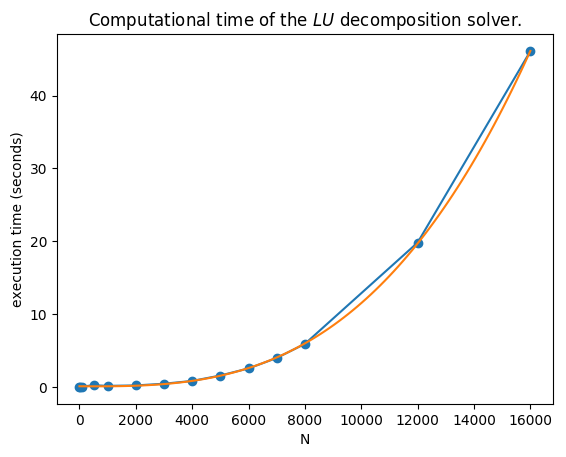

PyObject Text(0.5, 1.0, 'Computational time of the $LU$ decomposition solver.')

In [16]:
Ns_lin = LinRange(Ns[1], Ns[end], 100)

plot(Ns, times, "o-")
plot(Ns_lin, polyval(p, Ns_lin))
xlabel("N")
ylabel("execution time (seconds)")
title(L"Computational time of the $LU$ decomposition solver.")

## Computational work analysis: Counting mathematical operations

As we saw above, the computational time seems to grow with the matrix dimension
in a polynomial fashion.
While computer timings are always dubious (internally, there may be a lot of overhead, and/or
additional optimizations due to sophisticated algorithms, parallelization, processor execution tricks,
and much more),
we can get a rough handle on the computational work done while executing an algorithm by
counting the number of basic mathematical operations: additions, multiplications, etc...

Roughly, the computational work (and time) should be proportional to the number of
operations. In practice the time the processor spends on, say, a multiplication, may not even be a constant!
However, this method is about the best we can do without going into too many specifics.

This method is still very relevant when deciding on the type of algorithm you want to use.
The reason is scaling: An order $\mathcal{O}(n)$ algorithm is always going to beat an $\mathcal{O}(n^2)$
algorithm for a sufficiently large problem, no matter the fine details.

### Counting operations for the $LU$ factorization

We now explicitly count the number of operations.

From the formula we see that in oder to compute one element $L_{ij}$, we need to perform

* $j-1$ multiplications
* $j-2$ additions
* 1 subtraction
* 1 division,

which adds up to $2j-1$ operations.

Similarly, we find that to calculate $U_{ij}$ we need $2i-2$ operations.
Summing up the contributions for $L$ and $U$ individually:
$$
N_{\text{ops}} = \underbrace{\sum_{i=2}^n \sum_{j=1}^{i-1} (2j-1)}_{\text{from }L_{ij}}
+\underbrace{\sum_{i=1}^n \sum_{j=i}^n 2(i-1) }_{\text{from }U_{ij}} = \frac{1}{6} n (n-1)(4n+1),
$$

where we used the sum formulas
$$
\sum_{i=1}^n i = \frac{1}{2}n(n+1), \qquad \sum_{i=1}^n i^2 = \frac{1}{6} n (n+1)(2n+1).
$$

### Exercise: Show that both forward and backsubstitution each take $\frac{1}{2}n^2 + \frac{1}{2}n(n-1)$ operations. 

Adding up all contributions and ignoring terms of $\mathcal{O}(n)$, we find that the computational
cost of solving one linear system using $LU$ decomposition and forward and backsubstitution
is approximately
$$
N_\text{ops} \sim \frac{2}{3} n^3 + \frac{3}{2} n^2.
$$

The dominant power is $n^3$, which is in agreement with our timing results!

Improving computational time
---

Julia's backslash operator always uses the LU algorithm.
Often, we want to solve linear systems with the same matrix $A$
but for many different right hand sides $\mathbf{b}$.
For this case, Julia has a special in-built function that computes a matrix
factorization which can be re-used using the backslash operator.

In [17]:
# Let's solve a linear system using the "smart" factorize function

A = rand(10, 10)
b = rand(10)

A_f = factorize(A)

x = A_f \ b

10-element Array{Float64,1}:
  0.6292632738451284 
 -0.2987440944595089 
 -0.1971456052877696 
  0.8951318968274783 
 -0.1951644186592035 
 -0.4971665330975428 
  0.13970025917158552
 -0.6896142503729428 
 -0.6108985790381737 
  1.8298945631583132 

In [18]:
# Let's try a very large matrix and time the execution
A = rand(3000, 3000)
b = rand(3000)

function many_solves(A, b, N_solves)
    for i=1:N_solves
        A \ b
    end
end

function many_solves_factorized(A, b, N_solves)
    A_f = factorize(A)
    for i=1:N_solves
        A_f \ b
    end
end

many_solves_factorized (generic function with 1 method)

In [19]:
@time many_solves(A, b, 20)

  9.295230 seconds (11.54 k allocations: 1.343 GiB, 2.68% gc time)


In [20]:
@time many_solves_factorized(A, b, 20)

  0.575947 seconds (11.79 k allocations: 69.764 MiB, 0.92% gc time)


#### Note: You might be tempted to calculate the matrix inverse $A^{-1}$ explicitly and just multiply it to the right hand sides instead of re-using a factorization. However, this method is not only *less efficient*, it can also lead to worse rounding errors!

In [21]:
# We compare computing the inverse with using a matrix factorization

function many_solves_inverse(A, b, N_solves)
    # Julia can compute the inverse for us
    A_inv = inv(A)
    for i=1:N_solves
        A_inv * b
    end
end

@time many_solves_inverse(A, b, 20)

  1.795416 seconds (388.89 k allocations: 89.768 MiB, 0.39% gc time)


In [22]:
# Using the matrix inverse directly is not just slower, it can introduce bad rounding errors
# We construct a special matrix (an ill-conditioned one)

n = 500; 

X = rand(n, n); Q = qr(X).Q # random orthogonal matrix
d = 10 .^ LinRange(0, -12, n) # large range of eigenvalues
A = Q*diagm(0 => d)*Q' # random ill-conditioned matrix
x_true = randn(n) # random "true" solution
b = A*x_true; # RHS

In [23]:
# now we try to reconstruct x by solving:

x_backslash = A \ b

# Check whether by computing Ax we end up with b again.
# This is called the "residual"
norm(A*x_backslash - b)

1.862237872050988e-15

In [24]:
# and by a matrix inverse

x_inv = inv(A) * b
norm(A*x_inv - b)

2.112105876751482e-5

In [25]:
# The residual is significantly worse for inv(A)!

# Better decompositions for special matrices

In [26]:
# Let's try a special kind of matrix:
function solve_matrices()
    B = rand(5000, 5000)
    b = rand(5000)

    B_spd = B*B'

    @time B_spd \ b
    @time B_f = factorize(B_spd); B_f \ b;
end

solve_matrices();

  1.524310 seconds (7 allocations: 190.811 MiB, 4.07% gc time)
  1.078404 seconds (49.42 k allocations: 193.082 MiB, 0.77% gc time)


What happened here? Using the factorize function seems to be faster than
using the backslash operator!

The solution to this puzzle: The factorize function detected that A_spd was
a special matrix: It is symmetric and positive definite (SPD), and factorize
selected a special, faster solver for this matrix.
Many such specialized solvers exist (for instance, if your matrix
is upper or lower triangular already you can use forward or backsubstitution
directly).

Let us now discuss this special, faster algorithm for SPD matrices.

The Cholesky decomposition
---

Above, we saw that the factorize function was much faster on the matrix $B B^\top$ than on
$A$. The reason for this is that $B B^\top$ is *symmetric and positive definite* (SPD).
We can see that it is symmetric by checking
$$
(B B^\top)^\top = (B^\top)^\top B^\top = B B^\top.
$$

A matrix $A$ is called *positive definite* if for all vectors $\mathbf{x} \neq 0$,
$$
\mathbf{x}^\top A \mathbf{x} > 0.
$$
(This is equivalent to saying that all eigenvalues of $B$ are positive).

For our matrix $B B^\top$ we can see this again explicitly:
$$
\mathbf{x}^\top B B^\top \mathbf{x} = (B^\top \mathbf{x})^\top (B^\top \mathbf{x}) = \| B^\top \mathbf{x} \|^2 > 0,
$$
as long as $B$ is non-singular.

### Decomposing SPD matrices
Now for the great reveal! It turns out that *every* SPD matrix $A$ can be written in this form.
For every SPD matrix $A$, there is a (possibly non-unique) square matrix $L$ such that
$$
A = L L^\top.
$$

Even better: It turns out that $L$ can be chosen to be *lower triangular* (and then, it becomes unique)!
You can prove this fact rigorously by using the $LU$ decomposition (see Suli & Mayers, Theorem 3.2).

Here, just like for the $LU$ decomposition, we will assume that the decomposition exists, and then
derive it explicitly. Note already that we need to construct *only one* matrix factor, the other one is simply the transpose! This is one reason why the algorithm is faster than $LU$.

Since $A$ is symmetric, it suffices to look at $i \leq j$. We assume that the Cholesky decomposition exists:

$$
A_{ij} = \sum_{k=1}^{i} L_{ik} L_{jk}.
$$
This sum goes up to only $i$ because $L$ is lower triangular.

Let's look at $i=j$ first and rearrange:

$$
L_{ii}^2 = A_{ii} - \sum_{k=1}^{i-1} L_{ik}^2.
$$

This means that we can take the square root to find $L_{ii}$. Any sign of the square root will do, but let's pick the positive one. Then, we obtain

$$
L_{11} = \sqrt{A_{11}}, \quad L_{22} = \sqrt{A_{22} - L_{21}^2}, 
\quad L_{33} = \sqrt{A_{33} - L_{32}^2 - L_{31}^2}, \dots\quad L_{ii} = \sqrt{A_{ii} - \sum_{k=1}^{i-1} L_{ik}^2}.
$$

Like for the $LU$ decomposition, we can construct the diagonal elements of $L$ iteratively,
at each step using only elements that were computed in previous steps.
One can prove that if $A$ is SPD, then all terms under the square roots are strictly positive ($>0$,
again see Suli & Mayers, Section 3.2).

For the off-diagonal elements, the formula is very similar to the $LU$ decomposition.
We rearrange again to find

$$
L_{ji} = \frac{1}{L_{ii}} \left( A_{ij} - \sum_{k=1}^{i-1} L_{ik} L_{jk} \right), \qquad i < j.
$$

Again, the off-diagonal elements can be computed iteratively, one after the other,
at each step only using information computed at previous steps.
We first compute $L_{ii}$, and then all the $L_{i,i+1}, L_{i,i+2},\dots$.

### Computational work analysis

Evaluating $L_{ii}$ takes $i-1$ multiplications, $i-1$ subtractions, and one square root.
In total, $2i-1$ operations.
Similarly, computing the off-diagonals $L_{ji}$ also takes $2i-1$ operations.
Summing these up,

$$
N_\text{ops} = \sum_{i=1}^n \sum_{j=i}^n (2i-1) = \frac{1}{6}n(n+1)(2n+1).
$$

For large $n$, the leading term is $\frac{1}{3}n^3$, exactly half the value of the $LU$ decomposition.
Solving an entire linear system also requires forward and backsubstitution. The cost of these operations remains the same.

Some remarks on numerically solving linear systems
---

* Always use the appropriate factorization
* Never compute $A^{-1}$ directly, either use the backslash operator, the factorize method, or the appropriate factorization directly

In [27]:
# Let's compare LU and Cholesky for some matrices!

function compare_lu_chol_factorizations(N)
    B = rand(N, N)
    b = rand(N)

    B_spd = B*B'

    # factorization only
    @time lu(B_spd)
    @time cholesky(B_spd)
end

# as expected, the difference is approximatelt a speedup of 2x.
compare_lu_chol_factorizations(6000);

  2.537078 seconds (5 allocations: 274.704 MiB, 2.10% gc time)
  1.532634 seconds (6 allocations: 274.658 MiB, 1.82% gc time)


## The QR factorization
For any square matrix there exists a decomposition

$$
A = Q R,
$$

where $Q$ is *orthogonal*: $Q^\top Q = Q Q^\top = \mathbb{1}$ (this is the same as saying that the rows
of $Q$ form a set of mutually orthonormal vectors)
and $R$ is *upper triangular*.

This still works for non-square matrices with some modifications and can be used to solve
least squares problems.
However, here we focus on the square case.

The simplest algorithm for the QR decomposition proceeds by considering the matrix columns as vectors:

$$
A = [\mathbf{a}_1\; \mathbf{a}_2\; \dots \mathbf{a}_n].
$$

Consider now the Gram-Schmidt algorithm for contructing a set of *orthogonal*
vectors from the vectors $\{\mathbf{a}_i\}$:

\begin{align}
\mathbf{u}_1 &= \mathbf{a}_1, & & \mathbf{e}_1 = \frac{\mathbf{u}_1}{\|\mathbf{u}_1\|} \\
\mathbf{u}_2 &= \mathbf{a}_2 - (\mathbf{e}_1^\top \mathbf{a}_2)\, \mathbf{e}_1 , & & \mathbf{e}_2 = \frac{\mathbf{u}_2}{\|\mathbf{u}_2\|} \\
\mathbf{u}_3 &= \mathbf{a}_3 - (\mathbf{e}_1^\top \mathbf{a}_3)\, \mathbf{e}_1 
    - (\mathbf{e}_2^\top \mathbf{a}_3)\, \mathbf{e}_2 , & & \mathbf{e}_3 = \frac{\mathbf{u}_3}{\|\mathbf{u}_3\|} \\
    \vdots \\
\mathbf{u}_n &= \mathbf{a}_n - \sum_{j=1}^{n-1} (\mathbf{e}_j^\top \mathbf{e}_j)\, \mathbf{e}_j,
& & \mathbf{e}_n = \frac{\mathbf{u}_n}{\|\mathbf{u}_n\|}.
\end{align}

Then the vectors $\mathbf{e}_i$ are orthogonal:
$$
\mathbf{e}_i^\top \mathbf{e}_j = \begin{cases}
1, & i=j \\
0, & i\neq j
\end{cases}
$$

We can now revert the Gram-Schmidt algorithm and express the $\mathbf{a}_i$
in terms of our new orthogonal basis.
We use the fact that $\|\mathbf{u}_i\| = \mathbf{e}_i^\top\mathbf{a}_i$ and rearrange:

\begin{align}
\mathbf{a}_1 &= (\mathbf{e}_1^\top\mathbf{a}_1) \mathbf{e}_1 \\
\mathbf{a}_2 &= (\mathbf{e}_1^\top\mathbf{a}_2) \mathbf{e}_1 + (\mathbf{e}_2^\top\mathbf{a}_2) \mathbf{e}_2 \\
\vdots \\
\mathbf{a}_n &= \sum_{j=1}^n (\mathbf{e}_j^\top\mathbf{a}_n) \mathbf{e}_j.
\end{align}

This is a matrix product:

$$
A = Q R
$$

with 
$$
Q = [\mathbf{e}_1\; \mathbf{e}_2\;\dots\;\mathbf{e}_n],
$$

and
$$
R = \begin{pmatrix}
\mathbf{e}_1^\top \mathbf{a}_1 & \mathbf{e}_1^\top \mathbf{a}_2 & &  \dots & \mathbf{e}_1^\top \mathbf{a}_n \\
0 & \mathbf{e}_2^\top \mathbf{a}_2 & \mathbf{e}_2^\top \mathbf{a}_3 &  \dots \\
0 & 0& \mathbf{e}_3^\top \mathbf{a}_3 & \dots \\
\vdots \\
0 & 0 & \dots & 0 & \mathbf{e}_n^\top \mathbf{a}_n
\end{pmatrix}
$$

Clearly, $Q$ is orthogonal because its columns are an orthonormal set of vectors,
and clearly, $R$ upper triangular. So we found the $QR$ decomposition!

Note: In practice, the method using Gram-Schmidt is numerically unstable (prone to catastrophic loss of
precision), so one uses more sophisticated methods like Householder rotations or Givens rotations.

In [28]:
function qr_gs(A)
    """ Compute the QR decomposition of A using the Gram-Schmidt algorithm
    """
    N = size(A)[1]
    
    # setup matrices
    Q = zeros(N, N)
    R = zeros(N, N)
    
    for i=1:N
        # u is the i'th column of A
        u = A[:,i]
        
        # subtract the projections on the previous columns
        for j=1:i-1
            # ej is the j'th column of Q-- we have computed this in previous steps
            ej = Q[:,j]
            
            # compute inner product with the i'th column
            ej_dot_ai = (ej'*A[:,i])
            
            # subtract projection
            u -= ej_dot_ai*ej
            
            # save inner product in R
            R[j,i] = ej_dot_ai
        end
        
        # normalize
        unorm = norm(u)
        ei = u/norm(u)
        
        # store vectors
        Q[:,i] = ei
        R[i,i] = unorm
    end
    
    return Q, R
end

qr_gs (generic function with 1 method)

In [29]:
A = [1 2
3 4]

Q, R = qr_gs(A);

In [30]:
Q

2×2 Array{Float64,2}:
 0.316228   0.948683
 0.948683  -0.316228

In [31]:
R

2×2 Array{Float64,2}:
 3.16228  4.42719 
 0.0      0.632456

In [32]:
# Q is orthogonal
Q'*Q

2×2 Array{Float64,2}:
  1.0          -3.33067e-16
 -3.33067e-16   1.0        

In [33]:
Q*Q'

2×2 Array{Float64,2}:
  1.0          -3.33067e-16
 -3.33067e-16   1.0        

In [34]:
# Q*R gives A
Q*R

2×2 Array{Float64,2}:
 1.0  2.0
 3.0  4.0

### Solving linear systems with the QR decomposition

To solve a linear system

$$
A \mathbf{x} = \mathbf{b},
$$

we use $A = QR$ and solve the two systems
\begin{align}
Q \mathbf{y} &= \mathbf{b} \\
R \mathbf{x} &= \mathbf{y}.
\end{align}

Because $Q$ is orthogonal, the first equation is easily solved
$$
\mathbf{y} = Q^\top \mathbf{b},
$$

and the second equation can be solved using back-substitution.

This is most often used to solve *overconstrained* systems in the least squares sense,
when $A$ is a $n\times m$ matrix with $n\geq m$.
Then, the above algorithm yields

$$
A = Q R
$$

where $Q$ is a $n\times m$ matrix with orthogonal columns and $R$ is $m\times m$ upper triangular.
Therefore $Q^\top Q = \mathbb{1}_{m}$, but $QQ^\top \neq \mathbb{1}_n$. 

The least squares problem

$$
\operatorname{min}_{\mathbf{x}} \|A \mathbf{x} - \mathbf{b}\|^2
$$

leads to the normal equations (take the gradient with respect to $\mathbf{x}$ and set to zero)
$$
A^\top A \mathbf{x} = A^\top \mathbf{b}.
$$

Plugging in the $QR$ decomposition yields,
$$
A^\top A = (QR)^\top QR = R^\top \underbrace{Q^\top Q}_{=\mathbb{1}} R = R^\top R.
$$

The normal equations become
$$
R^\top R \mathbf{x} = R^\top Q^\top \mathbf{b},
$$

which we can invert
\begin{align}
\mathbf{x} &= (R^\top R)^{-1} R^\top Q^\top \mathbf{b} \\
            &= R^{-1} Q^\top \mathbf{b},
\end{align}

$R$ is guaranteed to be invertible because it is upper triangular
and all of its diagonal elements are nonzero (they are the vector norms $\|\mathbf{u}\|$).

So we solve the normal equations by solving
$$
R\mathbf{x} = Q^\top\mathbf{b},
$$
which is easily done by backsubstitution.

In [35]:
function qr_gs2(A)
    """ Compute the QR decomposition of A using the Gram-Schmidt algorithm,
    this time for general nxm matrices A with n ≥ m.
    """
    N, M = size(A)
    
    # setup matrices
    Q = zeros(N, M)
    R = zeros(M, M)
    
    for i=1:M
        u = A[:,i]
        for j=1:i-1
            ej = Q[:,j]
            
            # compute inner product
            ej_dot_ai = (ej'*A[:,i])
            
            # construct u
            u -= ej_dot_ai*ej
            
            # save inner product in R
            R[j,i] = ej_dot_ai
        end
        
        # normalize
        unorm = norm(u)
        ei = u/norm(u)
        
        # store vectors
        Q[:,i] = ei
        R[i,i] = unorm
    end
    
    return Q, R
end

qr_gs2 (generic function with 1 method)

In [36]:
A = [1 2
3 4
2 3
5 6]

4×2 Array{Int64,2}:
 1  2
 3  4
 2  3
 5  6

In [37]:
Q, R = qr_gs2(A)

([0.160128 0.757865; 0.480384 0.1624; 0.320256 0.460132; 0.800641 -0.433066], [6.245 8.00641; 0.0 0.947331])

In [38]:
Q

4×2 Array{Float64,2}:
 0.160128   0.757865
 0.480384   0.1624  
 0.320256   0.460132
 0.800641  -0.433066

In [39]:
# this is the identiy

Q'*Q

2×2 Array{Float64,2}:
 1.0          7.50473e-16
 7.50473e-16  1.0        

In [40]:
# this is not

Q*Q'

4×4 Array{Float64,2}:
  0.6  0.2       0.4        -0.2      
  0.2  0.257143  0.228571    0.314286 
  0.4  0.228571  0.314286    0.0571429
 -0.2  0.314286  0.0571429   0.828571 

In [41]:
R

2×2 Array{Float64,2}:
 6.245  8.00641 
 0.0    0.947331

In [42]:
# we get the original matrix back
Q*R

4×2 Array{Float64,2}:
 1.0  2.0
 3.0  4.0
 2.0  3.0
 5.0  6.0

In [43]:
# normal equations
A'*A

2×2 Array{Int64,2}:
 39  50
 50  65

In [44]:
R'*R

2×2 Array{Float64,2}:
 39.0  50.0
 50.0  65.0

In [45]:
# let's solve a least squares problem
b = [1, 2, 3, 4]

# solve normal equations directly
(A'*A) \ (A'*b)

2-element Array{Float64,1}:
 -0.14285714285714407
  0.7714285714285724 

In [46]:
# solve using QR decomposition
R \ Q'*b

2-element Array{Float64,1}:
 -0.14285714285714834
  0.7714285714285756 